# Exploratory Data Analysis

Explore specific attributes about the exports data

In [1]:
from database_settings import spark_utilities

In [2]:
from pyspark.sql.functions import substring, to_date, col, lpad, concat_ws, regexp_replace, trim
import matplotlib.pyplot as plt
import math
import numpy as np


In [3]:
# Get the data into a spark dataframe
df = spark_utilities.get_spark_df('peru_exports')

## Historical Data (all batches published)

In [4]:
# Get attributes
print('Number of attributes: ' + str(len(df.columns)))
# Show all possible keys
df.printSchema()

Number of attributes: 47
root
 |-- BATCH_WEEK: string (nullable = true)
 |-- CADU: string (nullable = true)
 |-- CAGE: string (nullable = true)
 |-- CALM: string (nullable = true)
 |-- CEMPTRA: string (nullable = true)
 |-- CENTFIN: string (nullable = true)
 |-- CEST: string (nullable = true)
 |-- CPAIDES: string (nullable = true)
 |-- CPUEDES: string (nullable = true)
 |-- CUNITRA: string (nullable = true)
 |-- CVIATRA: string (nullable = true)
 |-- DCOM: string (nullable = true)
 |-- DDIRCON: double (nullable = true)
 |-- DDIRPRO: string (nullable = true)
 |-- DK: string (nullable = true)
 |-- DK2: string (nullable = true)
 |-- DMAT: string (nullable = true)
 |-- DMER2: string (nullable = true)
 |-- DMER3: string (nullable = true)
 |-- DMER4: string (nullable = true)
 |-- DMER5: string (nullable = true)
 |-- DNOMBRE: string (nullable = true)
 |-- DNOMCON: double (nullable = true)
 |-- DNOMPRO: string (nullable = true)
 |-- FANO: string (nullable = true)
 |-- FANOREG: string (nullable

In [5]:
# Headings to work with:
# 07XXXXXXXX: Hortalizas, plantas, raíces y tubérculos alimenticios
# 08XXXXXXXX: Frutas y frutos comestibles; cortezas de agrios (cítricos), melones o sandías.

hs_to_work = ['07', '08']
filter = r"^("+ "|".join(hs_to_work) + ")" # this way we can do a filter with multiple values

#### PART_NANDI: Headings


In [6]:
headings = df.select('PART_NANDI')\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('HS')\
    .toPandas()

In [7]:
print('There is a total of {} headings in the data'.format(len(headings['HS'].value_counts())))
headings['HS'].value_counts()

There is a total of 174 headings in the data


0806100000    275701
0804400000    238944
0709200000    209276
0804502000    137941
0810400000    136288
               ...  
0802121000         1
0801111000         1
0813100000         1
0809210000         1
0802110000         1
Name: HS, Length: 174, dtype: int64

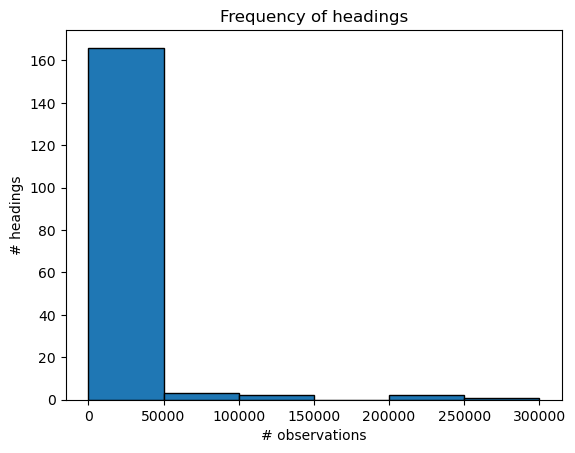

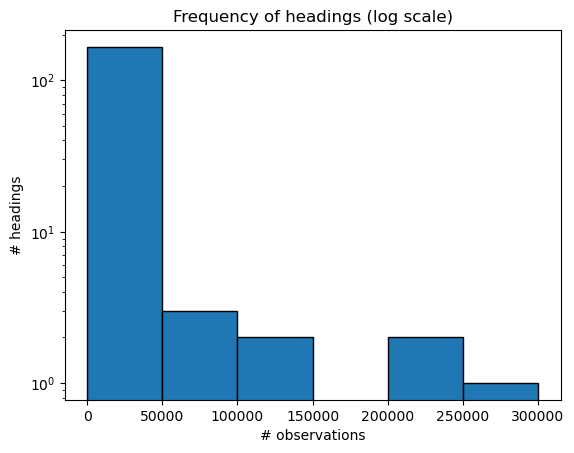

In [8]:
# Plot histogram with the frequency of headings
increments = 50000
bins = range(0, math.ceil(headings['HS'].value_counts().max()) + increments, increments)
plt.hist(headings['HS'].value_counts(), bins=bins, edgecolor='black')
plt.title('Frequency of headings')
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.show()

# Plot histogram in log scale
bins = range(0, math.ceil(headings['HS'].value_counts().max()) + increments, increments)
plt.hist(headings['HS'].value_counts(), bins=bins, edgecolor='black', log=True)
plt.title('Frequency of headings (log scale)')
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.show()

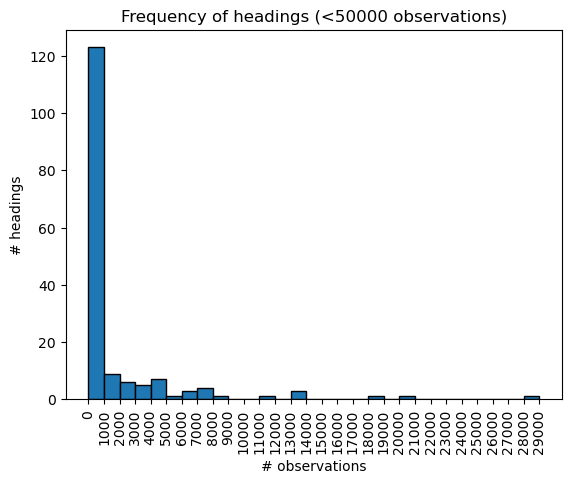

In [9]:
# Plot histogram to see what happens from 0 to 50000 observations
limit = 50000
increments = 1000
filtered_counts = headings['HS'].value_counts()[headings['HS'].value_counts() < limit]
bins = range(0, math.ceil(filtered_counts.max()) + increments, increments)
plt.hist(filtered_counts, bins=bins, edgecolor='black')
plt.title('Frequency of headings (<{} observations)'.format(limit))
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.xticks(bins, rotation='vertical')
plt.show()

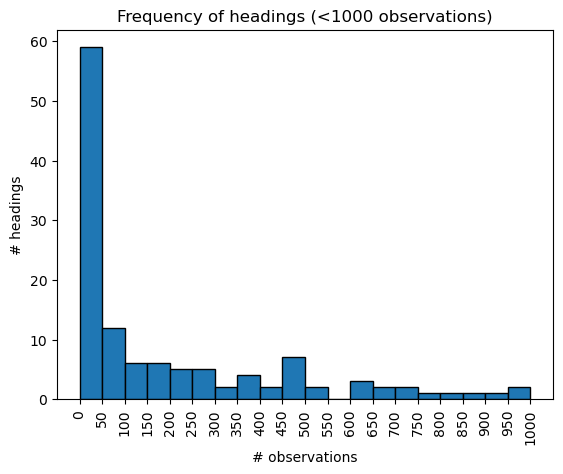

In [10]:
# Plot histogram to see what happens from 0 to 1000 observations
limit = 1000
increments = 50
filtered_counts = headings['HS'].value_counts()[headings['HS'].value_counts() < limit]
bins = range(0, math.ceil(filtered_counts.max()) + increments, increments)
plt.hist(filtered_counts, bins=bins, edgecolor='black')
plt.title('Frequency of headings (<{} observations)'.format(limit))
plt.xlabel('# observations')
plt.ylabel('# headings')
plt.xticks(bins, rotation='vertical')
plt.show()

In [11]:
# Percentage of headings kept if we set a threshold to remove headings with less than certain number of observations
observations_thresh = 10
percentage = round((headings['HS'].value_counts() > observations_thresh).mean() * 100,2)
print('By keeping headings with more than {} observations, we are keeping {} of {} headings ({}%).'.format(observations_thresh,len(headings['HS'].value_counts()[headings['HS'].value_counts() > observations_thresh]),len(headings['HS'].value_counts()),percentage ))
# Count of rows kept if we set a threshold to remove headings with less than certain number of observations
remaining_rows = len(headings[~headings['HS'].isin(headings['HS'].value_counts()[headings['HS'].value_counts() <= observations_thresh].index)])
print("By keeping headings with more than {} observations, we are keeping {} rows of {} ({}%).".format(observations_thresh,remaining_rows,len(headings),round(remaining_rows/len(headings)*100,4)))

By keeping headings with more than 10 observations, we are keeping 144 of 174 headings (82.76%).
By keeping headings with more than 10 observations, we are keeping 1469447 rows of 1469581 (99.9909%).


#### TUNIFIS: Measurement units

In [12]:
# Get all measurement unit types in the data of interest
measurement_units = df.select('PART_NANDI','TUNIFIS')\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('TUNIFIS')\
    .toPandas()
measurement_units['TUNIFIS'].value_counts()

KG    1469580
Kg          1
Name: TUNIFIS, dtype: int64

#### QUNIFIS: Amount exported in measurement units


In [13]:
# Get all measurement unit types in the data of interest
amounts_exported = df.select('PART_NANDI','QUNIFIS')\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('QUNIFIS')\
    .toPandas()

In [14]:
amounts_exported.sort_values(by='QUNIFIS', ascending=True, inplace=True)
amounts_exported

,QUNIFIS
1222619,0.000
855731,0.001
1103907,0.001
855732,0.001
1298224,0.001
...,...
1026590,750200.000
732126,750200.000
621939,847000.000
1340875,847000.000


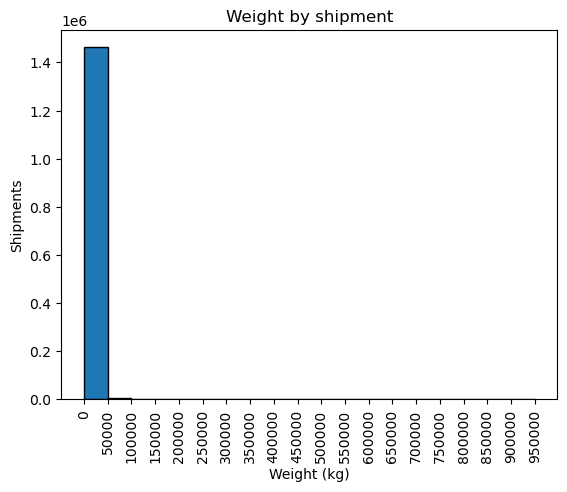

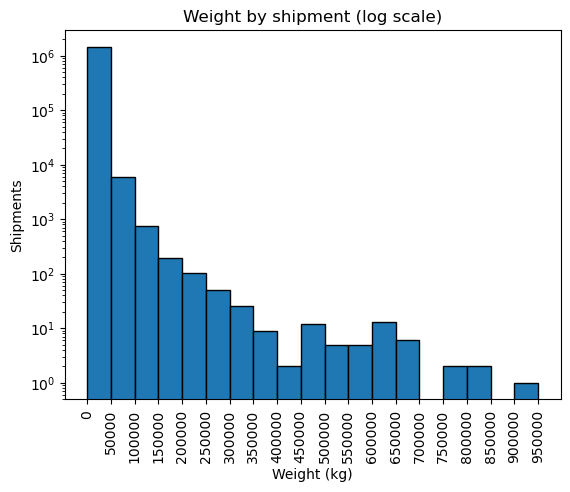

In [15]:
# Plot histogram with the frequency of weights by shipment
increments = 50000
bins = range(0, math.ceil(amounts_exported['QUNIFIS'].max()) + increments, increments)
plt.hist(amounts_exported['QUNIFIS'], bins=bins, edgecolor='black')
plt.title('Weight by shipment')
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.show()

# Plot histogram in log scale
bins = range(0, math.ceil(amounts_exported['QUNIFIS'].max()) + increments, increments)
plt.hist(amounts_exported['QUNIFIS'], bins=bins, edgecolor='black', log=True)
plt.title('Weight by shipment (log scale)')
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.show()

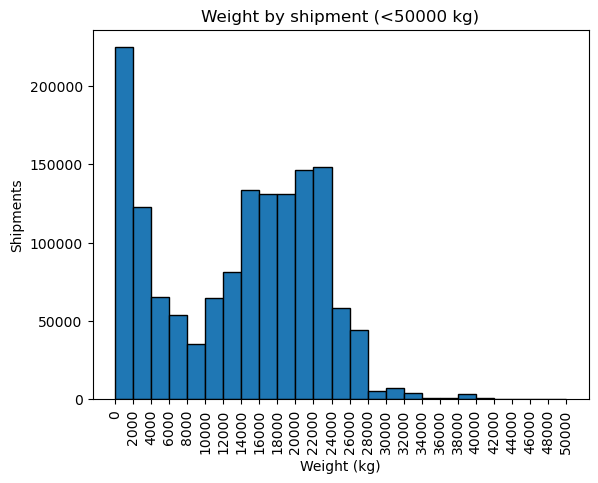

In [16]:
# Plot histogram to see what happens from 0 to 50000 kg
limit = 50000
increments = 2000
filtered = amounts_exported[amounts_exported['QUNIFIS']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.show()

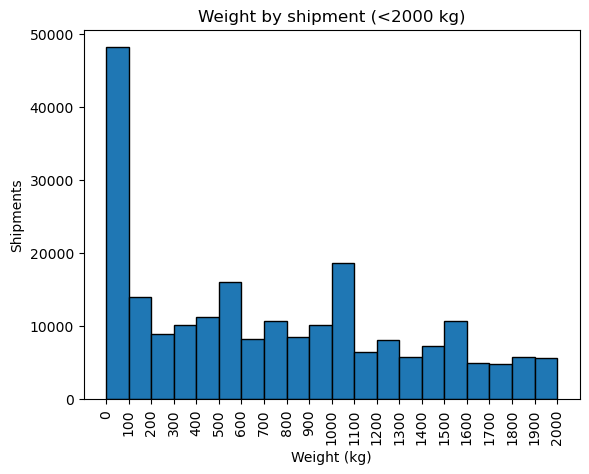

In [17]:
# Plot histogram to see what happens from 0 to 2000 kg
limit = 2000
increments = 100
filtered = amounts_exported[amounts_exported['QUNIFIS']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.show()

#### VPESNET: Net weight of goods


In [18]:
net_weight = df.select('PART_NANDI', 'VPESNET','QUNIFIS') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('VPESNET','QUNIFIS') \
    .toPandas()

In [19]:
net_weight.sort_values(by='VPESNET', ascending=True, inplace=True)
net_weight['VPESNET']

1222619         0.000
1298221         0.001
1298224         0.001
260845          0.001
855732          0.001
              ...    
1026590    750200.000
732126     750200.000
621939     847000.000
1340875    847000.000
916014     917280.000
Name: VPESNET, Length: 1469581, dtype: float64

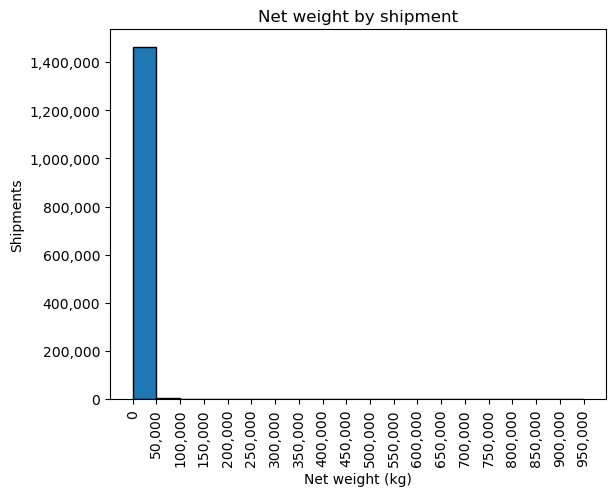

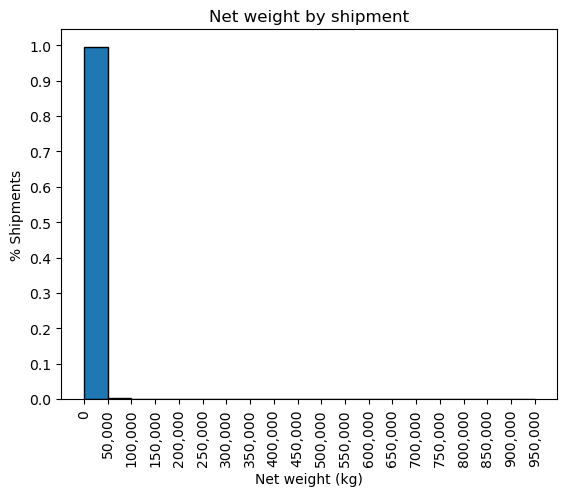

In [20]:
# Plot histogram with the frequency of weights by shipments
increments = 50000
bins = range(0, math.ceil(net_weight['VPESNET'].max()) + increments, increments)
plt.hist(net_weight['VPESNET'], bins=bins, edgecolor='black')
plt.title('Net weight by shipment')
plt.xlabel('Net weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Plot a density histogram
increments = 50000
bins = range(0, math.ceil(net_weight['VPESNET'].max()) + increments, increments)
plt.hist(net_weight['VPESNET'], bins=bins, edgecolor='black', weights=np.ones_like(net_weight[net_weight.columns[0]]) / len(net_weight))
plt.title('Net weight by shipment')
plt.xlabel('Net weight (kg)')
plt.ylabel('% Shipments')
plt.xticks(bins, rotation='vertical')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

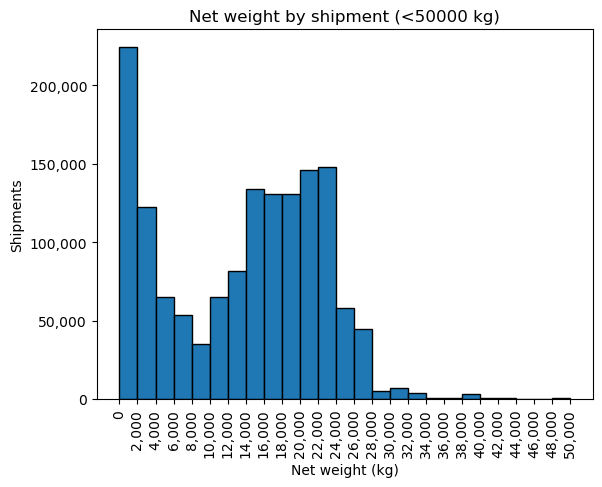

In [21]:
# Plot histogram to see what happens from 0 to 50000 kg
limit = 50000
increments = 2000
filtered = net_weight[net_weight['VPESNET']<limit]['VPESNET']
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Net weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Net weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

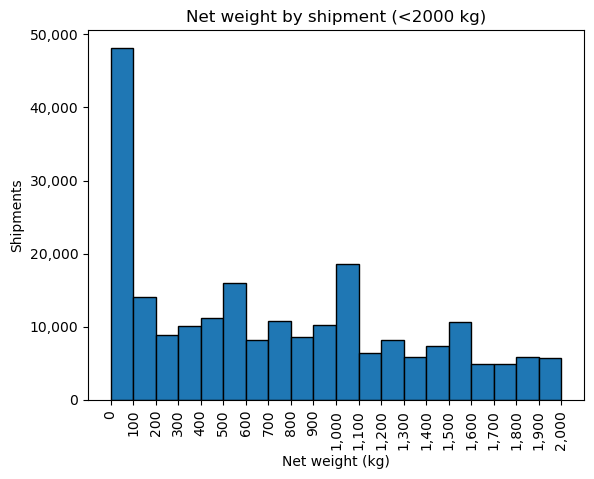

In [22]:
# Plot histogram to see what happens from 0 to 2000 kg
limit = 2000
increments = 100
filtered = net_weight[net_weight['VPESNET']<limit]['VPESNET']
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Net weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Net weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

In [23]:
# See if there are rows where VPESNET and QUINFIS are different
print('{}% of rows have differences between VPESNET and QUINFIS'.format(round(len(net_weight[net_weight['VPESNET'] != net_weight['QUNIFIS']])/len(net_weight),4)))
net_weight[net_weight['VPESNET'] != net_weight['QUNIFIS']]

0.0002% of rows have differences between VPESNET and QUINFIS


,VPESNET,QUNIFIS
1071305,0.419,0.418
1030892,2.590,3.590
1170842,2.590,3.590
296543,4.624,4.374
659638,16.532,16.545
...,...,...
131230,49760.000,49986.720
291568,53790.000,54000.000
380758,61640.000,30820.000
687074,74920.000,74980.080


In [24]:
# See the remaining data discarding exports of less than certain threshold
weight_thresh = 100
percentage_remaining = round((net_weight['VPESNET'][net_weight['VPESNET'] >= weight_thresh].count() / net_weight['VPESNET'].count()) * 100,3)
print('By removing those exports with less than {} kg, we keep {}% of the data'.format(weight_thresh, percentage_remaining))

By removing those exports with less than 100 kg, we keep 96.723% of the data


#### VPESBRU: Gross weight of goods


In [25]:
gross_weight = df.select('PART_NANDI', 'VPESBRU') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('VPESBRU') \
    .toPandas()

In [26]:
gross_weight.sort_values(by='VPESBRU', ascending=True, inplace=True)
gross_weight

,VPESBRU
1067177,0.000
1103906,0.001
1297707,0.001
1298221,0.001
1298224,0.001
...,...
1026590,812805.000
916014,917280.000
1340875,917280.000
621939,918420.000


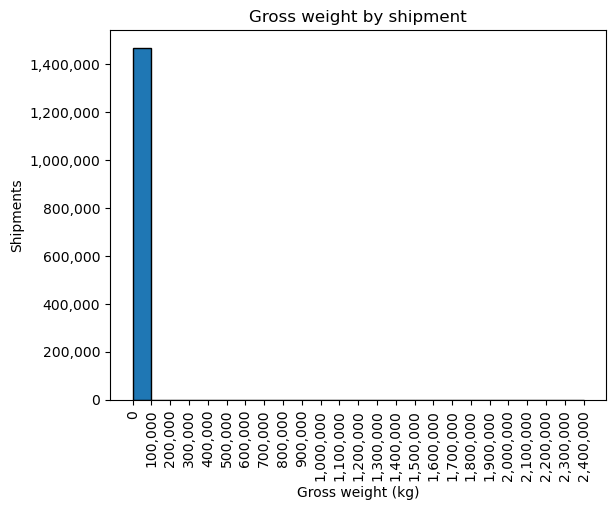

In [27]:
# Plot histogram with the frequency of gross weights by shipments
increments = 100000
bins = range(0, math.ceil(gross_weight['VPESBRU'].max()) + increments, increments)
plt.hist(gross_weight['VPESBRU'], bins=bins, edgecolor='black')
plt.title('Gross weight by shipment')
plt.xlabel('Gross weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

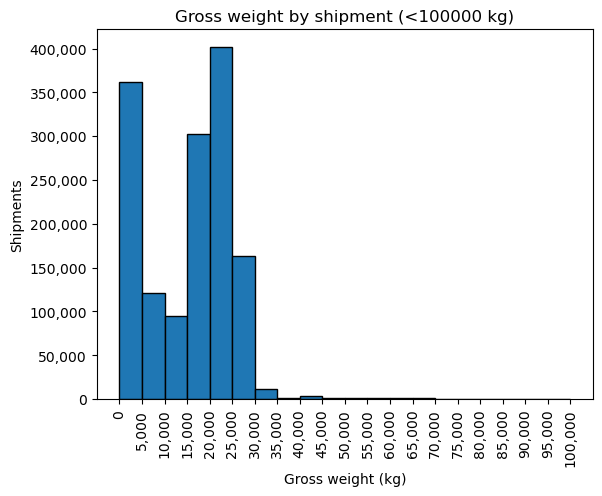

In [28]:
# Plot histogram to see what happens from 0 to 100,000 kg
limit = 100000
increments = 5000
filtered = gross_weight[gross_weight['VPESBRU']<limit]
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Gross weight by shipment (<{} kg)'.format(limit))
plt.xlabel('Gross weight (kg)')
plt.ylabel('Shipments')
plt.xticks(bins)
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

#### VFOBSERDOL: Value (USD) of goods at the time of board


In [29]:
value_usd = df.select('PART_NANDI', 'VFOBSERDOL','DCOM','FEMB') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('HS','VFOBSERDOL','DCOM','FEMB') \
    .toPandas()

In [30]:
value_usd.sort_values(by='VFOBSERDOL', ascending=True, inplace=True)
value_usd

,HS,VFOBSERDOL,DCOM,FEMB
253905,0703100000,0.00,CEBOLLA AMARILLA DULCE FRESCA,20150703
253880,0709600000,0.00,PIMIENTO MORRON ROJO FRESCO,20161224
625004,0805220000,0.00,MANDARINAS FRESCAS,20200604
253879,0709600000,0.00,PIMIENTO MORRON ROJO FRESCO,20161224
899257,0806100000,0.00,UVAS FRESCAS,20170321
...,...,...,...,...
1304037,0810400000,1642423.35,ARANDANOS FRESCOS,20170920
467446,0804400000,4552944.00,PALTAS FRESCAS,20190529
254348,0811909100,28260050.00,MANGO EN TROZOS IQF VARIEDAD KENT,20170223
254347,0811909100,38260050.00,MANGO EN TROZOS IQF VARIEDAD KENT,20170223


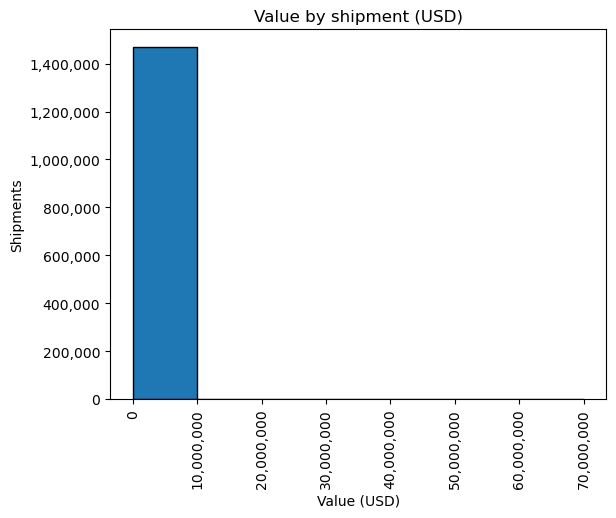

In [31]:
# Plot histogram of value of shipments (USD)
increments = 10000000
bins = range(0, math.ceil(value_usd['VFOBSERDOL'].max()) + increments, increments)
plt.hist(value_usd['VFOBSERDOL'], bins=bins, edgecolor='black')
plt.title('Value by shipment (USD)')
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

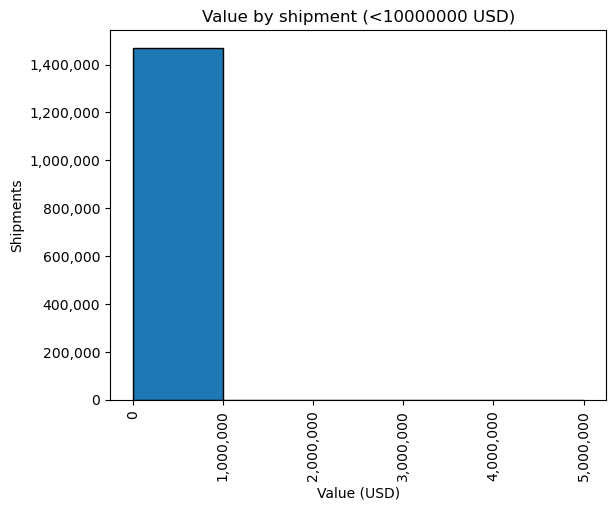

In [32]:
# Plot histogram to see what happens from 0 to 10,000,000 USD
limit = 10000000
increments = 1000000
filtered = value_usd[value_usd['VFOBSERDOL']<limit]['VFOBSERDOL']
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

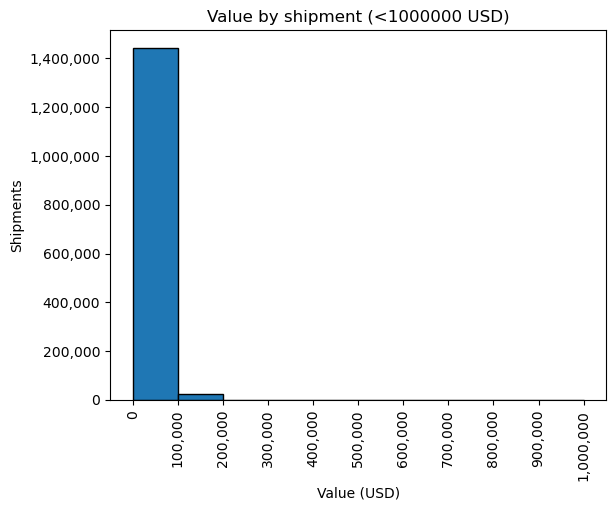

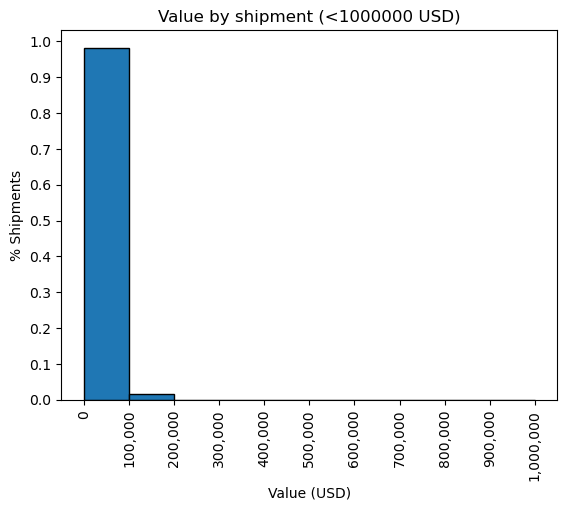

In [33]:
# Plot histogram to see what happens from 0 to 1,000,000 USD
limit = 1000000
increments = 100000
filtered = value_usd[value_usd['VFOBSERDOL']<limit]['VFOBSERDOL']
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Plot a density histogram
filtered = value_usd[value_usd['VFOBSERDOL']<limit]['VFOBSERDOL']
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black', weights=np.ones_like(filtered)/len(value_usd)) # the percentages shown are with respect to all the obsevations, not only to the subset
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('% Shipments')
plt.xticks(bins, rotation='vertical')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

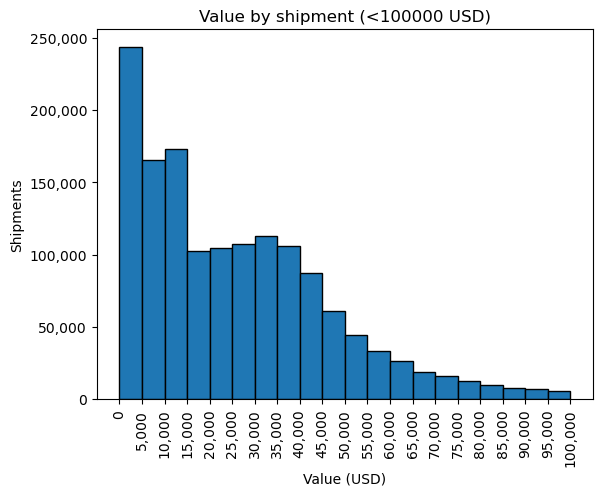

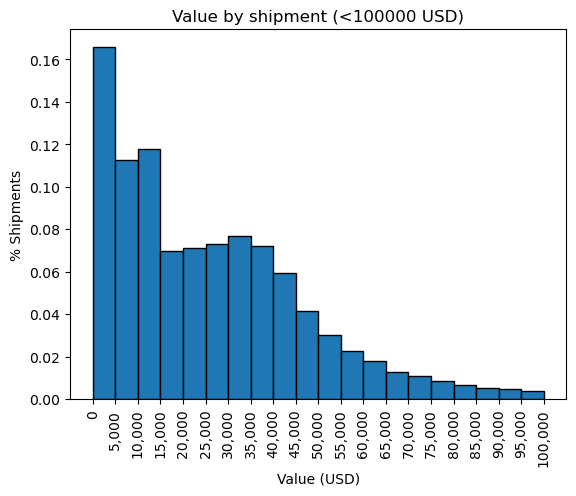

In [34]:
# Plot histogram to see what happens from 0 to 100,000 USD
limit = 100000
increments = 5000
filtered = value_usd[value_usd['VFOBSERDOL']<limit]['VFOBSERDOL']
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black')
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

# Plot a density histogram
filtered = value_usd[value_usd['VFOBSERDOL']<limit]['VFOBSERDOL']
bins = range(0, math.ceil(filtered.max()) + increments, increments)
plt.hist(filtered, bins=bins, edgecolor='black', weights=np.ones_like(filtered) / len(value_usd)) # the percentages shown are with respect to all the obsevations, not only to the subset
plt.title('Value by shipment (<{} USD)'.format(limit))
plt.xlabel('Value (USD)')
plt.ylabel('% Shipments')
plt.xticks(bins, rotation='vertical')
plt.ticklabel_format(style='plain')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

In [35]:
# See the remaining data discarding exports of less than certain USD threshold
value_thresh = 500
percentage_remaining = round((value_usd['VFOBSERDOL'][value_usd['VFOBSERDOL'] >= value_thresh].count() / value_usd['VFOBSERDOL'].count()) * 100,3)
print('By removing those exports of less than {} USD, we keep {}% of the data'.format(value_thresh, percentage_remaining))

By removing those exports of less than 500 USD, we keep 95.416% of the data


#### CPAIDES: Destination country code


In [36]:
destination = df.select('PART_NANDI', 'CPAIDES') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('CPAIDES') \
    .toPandas()

In [37]:
destination['CPAIDES'].value_counts()

US    533074
NL    286265
ES    121270
GB     97274
CL     65117
       ...  
MM         1
IS         1
GY         1
DM         1
TK         1
Name: CPAIDES, Length: 128, dtype: int64

#### NDOC, DNOMBRE: Exporter's tax id and name


In [38]:
exporter = df.select('PART_NANDI', 'NDOC', 'DNOMBRE') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .select('NDOC', 'DNOMBRE') \
    .orderBy(col("NDOC"),col("DNOMBRE"))\
    .toPandas()

In [39]:
# Show any rows with empty values in any column
exporter[exporter.isnull().any(axis=1)]

,NDOC,DNOMBRE


In [40]:
# See if there are ids associated with unknown names
exporter[(exporter['NDOC'] =='NaN') | (exporter['DNOMBRE']=='NaN')]

,NDOC,DNOMBRE
167,10013231821,NaN
168,10013231821,NaN
169,10013231821,NaN
170,10013294947,NaN
171,10013294947,NaN
...,...,...
1459741,NaN,NaN
1459742,NaN,NaN
1459743,NaN,NaN
1459744,NaN,NaN


In [41]:
# See if there are exporter's ids associated with more than one exporter's name
print('Documents for which entity resolution is needed: '+str((exporter.drop_duplicates()['NDOC'].value_counts() > 1).sum())+' of '+str(len(exporter.drop_duplicates()['NDOC'].value_counts())))
exporter.drop_duplicates()['NDOC'].value_counts()

Documents for which entity resolution is needed: 169 of 2661


20484328162    3
20609618354    3
20605936505    2
20608603477    2
20604351503    2
              ..
20536140787    1
20536196499    1
20536259911    1
20536402226    1
No Disponib    1
Name: NDOC, Length: 2661, dtype: int64

In [42]:
# Check quantity of anonymous shipments
print('Anonymous shipments: {} of {} ({}%)'.format(
    str(len(exporter[exporter['NDOC']=='No Disponib'])),
    str(len(exporter)),
    str(round(len(exporter[exporter['NDOC']=='No Disponib'])/len(exporter),3))))

Anonymous shipments: 9835 of 1469581 (0.007%)


#### DCOM, DMER2, DMER3, DMER4, DMER5: Good descriptions


In [43]:
description = df.select('PART_NANDI', 'DCOM','DMER2','DMER3','DMER4','DMER5') \
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .filter(col("HS").rlike(filter)) \
    .withColumn("MERGED", concat_ws(" ", col("DCOM"), col("DMER2"), col("DMER3"), col("DMER4"), col("DMER5"))) \
    .withColumn("MERGED", regexp_replace(col("MERGED"), "NaN", "")) \
    .withColumn("MERGED", trim(col("MERGED"))) \
    .select('HS', 'MERGED') \
    .toPandas()

In [44]:
description

,HS,MERGED
0,0701100000,PAPA SECA AMARILLA
1,0701100000,PAPA AMARILLA
2,0702000000,"TOMATE FRESCO EN BANDEJAS EN 1,180 BANDEJAS PL..."
3,0702000000,TOMATE FRESCO EN BANDEJAS EN 20 BANDEJAS PLAST...
4,0702000000,"TOMATE FRESCO EN BANDEJAS EN 1,200 BANDEJAS PL..."
...,...,...
1469576,0713609000,FREJOL DE PALO SECO EN SACOS DE 100 LIBRAS FRE...
1469577,0803901900,PLATANO DE ISLA FRESCO 03 CAJAS PLATANO DE ISL...
1469578,0803901900,PLATANO ISLA FRESCO 05 CAJAS PLATANO ISLA FRES...
1469579,0712390000,HONGO DESHIDRATADO EN TROZOSEN BOLSAS DE PAPEL...
